# Texas Hold'em Poker Data Analytics

This notebook analyzes poker hand logs from multiple sessions.

In [1]:
import pandas as pd
import re
from pathlib import Path
from typing import Dict, List
from collections import defaultdict

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

Bad pipe message: %s [b' 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/143.0.0.0 Sa']
Bad pipe message: %s [b'ri/537.36\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/', b'ng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7\r\nAccept-Encoding: gzip, deflate, br, zstd\r\nA']
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/user/ppp/venv/lib/python3.11/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/user/ppp/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 577, in shell_channel_thread_main
    _, msg2 = self.session.feed_identities(msg, copy=False)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/user/ppp/venv/lib/python3.11/site-packages/jupyter_client/session.py", line 993, in feed_identities
    raise ValueError(msg)
ValueError: DELIM not in msg_list
ERROR:tornado.general:

## 1. Load Data

In [2]:
# Load all CSV files
data_dir = Path('data')
csv_files = sorted(data_dir.glob('*.csv'))

dfs = []
for csv_file in csv_files:
    print(f"Loading {csv_file.name}...")
    df = pd.read_csv(csv_file)
    df['source_file'] = csv_file.name
    dfs.append(df)

raw_data = pd.concat(dfs, ignore_index=True)
raw_data['at'] = pd.to_datetime(raw_data['at'])
raw_data = raw_data.sort_values('order').reset_index(drop=True)

print(f"\nTotal entries: {len(raw_data):,}")
print(f"Date range: {raw_data['at'].min()} to {raw_data['at'].max()}")
raw_data.head(10)

Loading 0101_logdata.csv...
Loading 1230_logdata.csv...
Loading 1231_logdata.csv...

Total entries: 42,714
Date range: 2025-12-30 09:46:25.557000+00:00 to 2026-01-01 20:42:55.207000+00:00


,entry,at,order,source_file
0,"""jho @ t3NhL8TnYz"" checks",2025-12-30 09:46:25.557000+00:00,176708798555700,1230_logdata.csv
1,"""LIT2 @ Mw0SATaN53"" bets 6000",2025-12-30 09:46:27.945000+00:00,176708798794500,1230_logdata.csv
2,"""zxc @ uaMcxyz0Rj"" calls 6000",2025-12-30 09:46:29.851000+00:00,176708798985100,1230_logdata.csv
3,"""jho @ t3NhL8TnYz"" calls 6000",2025-12-30 09:46:36.922000+00:00,176708799692200,1230_logdata.csv
4,"Turn: 6♣, 8♥, 5♣ [8♣]",2025-12-30 09:46:37.728000+00:00,176708799772800,1230_logdata.csv
5,"""zxc @ uaMcxyz0Rj"" checks",2025-12-30 09:46:39.109000+00:00,176708799910900,1230_logdata.csv
6,"""jho @ t3NhL8TnYz"" checks",2025-12-30 09:46:42.547000+00:00,176708800254700,1230_logdata.csv
7,"""LIT2 @ Mw0SATaN53"" checks",2025-12-30 09:46:43.635000+00:00,176708800363500,1230_logdata.csv
8,"River: 6♣, 8♥, 5♣, 8♣ [2♣]",2025-12-30 09:46:44.460000+00:00,176708800446000,1230_logdata.csv
9,"""zxc @ uaMcxyz0Rj"" checks",2025-12-30 09:46:46.893000+00:00,176708800689300,1230_logdata.csv


## 2. Parse Log Entries

In [3]:
def extract_hand_info(entry: str) -> Dict:
    info = {'type': 'unknown', 'raw': entry}
    
    if '-- starting hand' in entry:
        match = re.search(r'hand #(\d+) \(id: ([^\)]+)\)', entry)
        if match:
            info['type'] = 'hand_start'
            info['hand_number'] = int(match.group(1))
            info['hand_id'] = match.group(2)
        dealer_match = re.search(r'dealer: "([^"]+)"', entry)
        if dealer_match:
            info['dealer'] = dealer_match.group(1)
    
    elif '-- ending hand' in entry:
        match = re.search(r'hand #(\d+)', entry)
        if match:
            info['type'] = 'hand_end'
            info['hand_number'] = int(match.group(1))
    
    elif 'Player stacks:' in entry:
        info['type'] = 'player_stacks'
        players = re.findall(r'#(\d+) "([^"]+)" \((\d+)\)', entry)
        info['stacks'] = {player[1]: int(player[2]) for player in players}
    
    elif 'posts a small blind' in entry:
        match = re.search(r'"([^"]+)" posts a small blind of (\d+)', entry)
        if match:
            info.update({'type': 'small_blind', 'player': match.group(1), 'amount': int(match.group(2))})
    
    elif 'posts a big blind' in entry:
        match = re.search(r'"([^"]+)" posts a big blind of (\d+)', entry)
        if match:
            info.update({'type': 'big_blind', 'player': match.group(1), 'amount': int(match.group(2))})
    
    elif entry.startswith('Flop:'):
        info['type'] = 'flop'
        info['cards'] = re.findall(r'[2-9TJQKA][♠♥♦♣]', entry)
    
    elif entry.startswith('Turn:'):
        info['type'] = 'turn'
        info['cards'] = re.findall(r'[2-9TJQKA][♠♥♦♣]', entry)
    
    elif entry.startswith('River:'):
        info['type'] = 'river'
        info['cards'] = re.findall(r'[2-9TJQKA][♠♥♦♣]', entry)
    
    elif ' calls ' in entry:
        match = re.search(r'"([^"]+)" calls (\d+)', entry)
        if match:
            info.update({'type': 'call', 'player': match.group(1), 'amount': int(match.group(2))})
    
    elif ' bets ' in entry:
        match = re.search(r'"([^"]+)" bets (\d+)', entry)
        if match:
            info.update({'type': 'bet', 'player': match.group(1), 'amount': int(match.group(2))})
    
    elif ' raises to ' in entry:
        match = re.search(r'"([^"]+)" raises to (\d+)', entry)
        if match:
            info.update({'type': 'raise', 'player': match.group(1), 'amount': int(match.group(2))})
    
    elif ' checks' in entry:
        match = re.search(r'"([^"]+)" checks', entry)
        if match:
            info.update({'type': 'check', 'player': match.group(1)})
    
    elif ' folds' in entry:
        match = re.search(r'"([^"]+)" folds', entry)
        if match:
            info.update({'type': 'fold', 'player': match.group(1)})
    
    elif ' shows a ' in entry:
        match = re.search(r'"([^"]+)" shows a (.+)\.', entry)
        if match:
            info['type'] = 'show'
            info['player'] = match.group(1)
            info['cards'] = re.findall(r'[2-9TJQKA][♠♥♦♣]', match.group(2))
    
    elif ' collected ' in entry and ' from pot' in entry:
        match = re.search(r'"([^"]+)" collected (\d+) from pot', entry)
        if match:
            info.update({'type': 'pot_collected', 'player': match.group(1), 'amount': int(match.group(2))})
        hand_match = re.search(r'with (.+?) \(combination: ([^)]+)\)', entry)
        if hand_match:
            info['winning_hand'] = hand_match.group(1)
            info['combination'] = hand_match.group(2)
    
    elif 'Uncalled bet' in entry:
        match = re.search(r'Uncalled bet of (\d+) returned to "([^"]+)"', entry)
        if match:
            info.update({'type': 'uncalled_bet', 'amount': int(match.group(1)), 'player': match.group(2)})
    
    return info

print("Parser function loaded successfully!")

Parser function loaded successfully!


---

## 📚 Notebook Guide

This notebook now includes:

1. **Data Loading** - Import and parse poker hand logs
2. **Parser Functions** - Extract structured data from logs  
3. **Hand Parsing** - Build complete hand histories
4. **Player Statistics** - Win rates, ROI, profit/loss rankings
5. **Key Insights** - High-level summary of results
6. **Winning Hands** - Distribution of hand types
7. **Pot Analysis** - Size statistics and biggest pots
8. **Visual Charts** - 4 different visualizations
9. **Final Conclusions** - Strategic takeaways
10. **Player ID Mapping** - ✏️ **EDITABLE** dictionary to merge player accounts
11. **All-In EV Analysis** - Performance in all-in situations
12. **Positional Analysis** - Stats by position (BTN, BB, CO, etc.)
13. **Hand Range Matrix** - 13x13 colorful heatmap showing showdown ranges

### How to Use:

- **Run cells in order** from top to bottom
- **Edit Player Mapping** (Section 10) to merge multiple accounts
- **Change selected_player** in the range chart cell to analyze different players
- All charts are interactive and will display automatically

---

## 3. Parse All Hands

In [4]:
# Parse all hands
def parse_hands(data: pd.DataFrame) -> List[Dict]:
    hands = []
    current_hand = None

    for idx, row in data.iterrows():
        entry = row['entry']
        info = extract_hand_info(entry)
        info['timestamp'] = row['at']

        if info['type'] == 'hand_start':
            current_hand = {
                'hand_number': info['hand_number'],
                'hand_id': info['hand_id'],
                'dealer': info.get('dealer'),
                'start_time': info['timestamp'],
                'actions': [],
                'players': {},
                'board': [],
                'pot': 0,
                'winner': None,
                'winning_hand': None
            }

        elif info['type'] == 'hand_end':
            if current_hand:
                current_hand['end_time'] = info['timestamp']
                hands.append(current_hand)
                current_hand = None

        elif current_hand:
            if info['type'] == 'player_stacks':
                for player, stack in info['stacks'].items():
                    current_hand['players'][player] = {'initial_stack': stack, 'invested': 0}

            elif info['type'] in ['small_blind', 'big_blind', 'call', 'bet', 'raise']:
                player = info['player']
                amount = info['amount']
                if player in current_hand['players']:
                    current_hand['players'][player]['invested'] = \
                        current_hand['players'][player].get('invested', 0) + amount

            elif info['type'] in ['flop', 'turn', 'river']:
                current_hand['board'] = info['cards']

            elif info['type'] == 'show':
                player = info['player']
                if player in current_hand['players']:
                    current_hand['players'][player]['hole_cards'] = info['cards']

            elif info['type'] == 'pot_collected':
                current_hand['winner'] = info['player']
                current_hand['pot'] = info['amount']
                current_hand['winning_hand'] = info.get('winning_hand')

    return hands

hands = parse_hands(raw_data)
print(f"✓ Parsed {len(hands):,} complete poker hands")

✓ Parsed 2,386 complete poker hands


## 10. Player Identity Mapping (Editable)

In [5]:
# PLAYER IDENTITY MAPPING - Edit this dictionary to merge multiple IDs
# Format: "player_id": "username"

# First, let's see all unique player IDs and extract username mapping
all_player_ids = set()
for hand in hands:
    all_player_ids.update(hand['players'].keys())

# Function to extract ID and username from full player string
def parse_player_string(player_str):
    """Extract username and ID from 'Username @ ID' format"""
    if ' @ ' in player_str:
        parts = player_str.split(' @ ')
        username = parts[0].strip()
        player_id = parts[1].strip()
        return player_id, username
    return player_str, player_str  # Fallback if format is different

print("📋 ALL UNIQUE PLAYER IDs FOUND:")
print("=" * 80)
print(f"{'ID':<20} | Username")
print("-" * 80)

# Create initial mapping
initial_mapping = {}
for player_str in sorted(all_player_ids):
    player_id, username = parse_player_string(player_str)
    initial_mapping[player_id] = username
    print(f"{player_id:<20} | {username}")

print(f"\n✏️  EDIT THE DICTIONARY BELOW to merge multiple IDs to the same username:")
print("=" * 80)
print("Example: To merge accounts, set multiple IDs to the same username:")
print('  "g0FfVCh6gI": "Justin",')
print('  "xyz12345": "Justin",  # Same player, different ID')
print("=" * 80)

# EDIT THIS DICTIONARY TO MAP PLAYER IDs TO USERNAMES
# Format: "player_id": "username"
player_id_mapping = {
    "3jIWLYiXzx": "LIT2",
    "thyyJUIpI9": "LIT",
    "e2LT3dd3Tx": "black",
    "u341hEhZ9E": "zxc2",
    "Mw0SATaN53": "LIT",  # If this is the same as LIT above, they'll be merged
    "uaMcxyz0Rj": "zxc",
    "xpbZinNQx9": "9917..",
    # "Mw0SATaN53": "LIT2",  # Duplicate key - if LIT2 uses this ID too
    "xswHkyUXqL": "Z9z9",  # Note: also used by O9O9
    "cIaXP7lyE_": "zxc2",
    "t3NhL8TnYz": "jho",
    "Ek559oOV8c": "9917.",
    "g0FfVCh6gI": "Justin",
    "eLlYR19TDN": "Black",
    # "xswHkyUXqL": "O9O9",  # Same ID as Z9z9 - edit to merge
}

# Add any missing IDs with their default usernames
for player_id, username in initial_mapping.items():
    if player_id not in player_id_mapping:
        player_id_mapping[player_id] = username

# Create reverse lookup (full player string -> unified name)
# This allows us to look up by the original "Username @ ID" format
player_full_to_unified = {}
for player_str in all_player_ids:
    player_id, _ = parse_player_string(player_str)
    unified_name = player_id_mapping.get(player_id, player_str)
    player_full_to_unified[player_str] = unified_name

print(f"\n✓ Player mapping loaded with {len(player_id_mapping)} ID entries")
print(f"✓ Edit the dictionary above to merge players with different IDs")
print(f"✓ Re-run this cell after editing to apply changes")

# Show which IDs map to the same username (merged accounts)
from collections import defaultdict
username_to_ids = defaultdict(list)
for pid, uname in player_id_mapping.items():
    username_to_ids[uname].append(pid)

merged = {uname: ids for uname, ids in username_to_ids.items() if len(ids) > 1}
if merged:
    print(f"\n🔗 MERGED ACCOUNTS (multiple IDs → same username):")
    for username, ids in merged.items():
        print(f"   {username}: {', '.join(ids)}")

📋 ALL UNIQUE PLAYER IDs FOUND:
ID                   | Username
--------------------------------------------------------------------------------
Ek559oOV8c           | 9917.
xpbZinNQx9           | 9917..
eLlYR19TDN           | Black
g0FfVCh6gI           | Justin
Mw0SATaN53           | LIT
thyyJUIpI9           | LIT
3jIWLYiXzx           | LIT2
Mw0SATaN53           | LIT2
xswHkyUXqL           | O9O9
xswHkyUXqL           | Z9z9
e2LT3dd3Tx           | black
t3NhL8TnYz           | jho
uaMcxyz0Rj           | zxc
cIaXP7lyE_           | zxc2
u341hEhZ9E           | zxc2

✏️  EDIT THE DICTIONARY BELOW to merge multiple IDs to the same username:
Example: To merge accounts, set multiple IDs to the same username:
  "g0FfVCh6gI": "Justin",
  "xyz12345": "Justin",  # Same player, different ID

✓ Player mapping loaded with 13 ID entries
✓ Edit the dictionary above to merge players with different IDs
✓ Re-run this cell after editing to apply changes

🔗 MERGED ACCOUNTS (multiple IDs → same username):
   

## 4. Player Statistics & Rankings

In [6]:
# Calculate comprehensive player statistics (with ID mapping)
def get_player_statistics(hands: List[Dict]) -> pd.DataFrame:
    player_stats = defaultdict(lambda: {
        'hands_played': 0,
        'hands_won': 0,
        'total_invested': 0,
        'total_won': 0
    })

    for hand in hands:
        for player, data in hand['players'].items():
            # Map to unified player name
            unified_player = player_full_to_unified.get(player, player)
            
            player_stats[unified_player]['hands_played'] += 1
            player_stats[unified_player]['total_invested'] += data.get('invested', 0)

            if hand['winner'] == player:
                player_stats[unified_player]['hands_won'] += 1
                player_stats[unified_player]['total_won'] += hand['pot']

    # Calculate derived metrics
    for player in player_stats:
        stats = player_stats[player]
        stats['net_profit'] = stats['total_won'] - stats['total_invested']
        stats['win_rate'] = (stats['hands_won'] / stats['hands_played'] * 100) if stats['hands_played'] > 0 else 0
        stats['roi'] = (stats['net_profit'] / stats['total_invested'] * 100) if stats['total_invested'] > 0 else 0

    return pd.DataFrame.from_dict(player_stats, orient='index').sort_values('net_profit', ascending=False)

player_stats = get_player_statistics(hands)

print("=" * 80)
print("PLAYER PERFORMANCE RANKINGS")
print("=" * 80)
print(player_stats.round(2))
print("\n")

PLAYER PERFORMANCE RANKINGS
        hands_played  hands_won  total_invested  total_won  net_profit  \
LIT2             238         58         2949887    3169262      219375   
black            138         53          874400     550500     -323900   
zxc              338         83         1677052     958900     -718152   
9917..           259         93         2957750    1055800    -1901950   
jho              927        185         8757889    5765580    -2992309   
9917.            502        101        10374661    7346542    -3028119   
LIT              918        232         7756908    4578919    -3177989   
zxc2            1117        220        13220352    9578791    -3641561   
Justin          1201        352        17478668   13004042    -4474626   
Black           1136        347        13039700    8555400    -4484300   
Z9z9            1892        662        27695262   18408912    -9286350   

        win_rate    roi  
LIT2       24.37   7.44  
black      38.41 -37.04  
zxc  

## 5. Key Insights & Conclusions

In [7]:
# Generate key insights
print("📊 KEY INSIGHTS FROM POKER DATA")
print("=" * 80)

# Overall statistics
print(f"\n🎲 GAME OVERVIEW:")
print(f"   • Total Hands Played: {len(hands):,}")
print(f"   • Date Range: {raw_data['at'].min().strftime('%Y-%m-%d')} to {raw_data['at'].max().strftime('%Y-%m-%d')}")
print(f"   • Total Players: {len(player_stats)}")
print(f"   • Total Money Circulated: ${player_stats['total_invested'].sum():,.0f}")

# Winner analysis
winner = player_stats.iloc[0]
print(f"\n🏆 TOP PERFORMER:")
print(f"   • Player: {player_stats.index[0]}")
print(f"   • Net Profit: ${winner['net_profit']:,.0f}")
print(f"   • Win Rate: {winner['win_rate']:.1f}%")
print(f"   • ROI: {winner['roi']:.1f}%")
print(f"   • Hands Won: {int(winner['hands_won'])} / {int(winner['hands_played'])}")

# Biggest loser
loser = player_stats.iloc[-1]
print(f"\n📉 BIGGEST LOSER:")
print(f"   • Player: {player_stats.index[-1]}")
print(f"   • Net Loss: ${loser['net_profit']:,.0f}")
print(f"   • Win Rate: {loser['win_rate']:.1f}%")
print(f"   • ROI: {loser['roi']:.1f}%")

# Profitable vs unprofitable
profitable = (player_stats['net_profit'] > 0).sum()
unprofitable = (player_stats['net_profit'] < 0).sum()
print(f"\n💰 PROFITABILITY:")
print(f"   • Profitable Players: {profitable}")
print(f"   • Unprofitable Players: {unprofitable}")
print(f"   • Break-even Players: {len(player_stats) - profitable - unprofitable}")

# Activity levels
most_active = player_stats.nlargest(3, 'hands_played')
print(f"\n🎯 MOST ACTIVE PLAYERS:")
for i, (player, data) in enumerate(most_active.iterrows(), 1):
    print(f"   {i}. {player}: {int(data['hands_played'])} hands (Win Rate: {data['win_rate']:.1f}%)")

📊 KEY INSIGHTS FROM POKER DATA

🎲 GAME OVERVIEW:
   • Total Hands Played: 2,386
   • Date Range: 2025-12-30 to 2026-01-01
   • Total Players: 11
   • Total Money Circulated: $106,782,529

🏆 TOP PERFORMER:
   • Player: LIT2
   • Net Profit: $219,375
   • Win Rate: 24.4%
   • ROI: 7.4%
   • Hands Won: 58 / 238

📉 BIGGEST LOSER:
   • Player: Z9z9
   • Net Loss: $-9,286,350
   • Win Rate: 35.0%
   • ROI: -33.5%

💰 PROFITABILITY:
   • Profitable Players: 1
   • Unprofitable Players: 10
   • Break-even Players: 0

🎯 MOST ACTIVE PLAYERS:
   1. Z9z9: 1892 hands (Win Rate: 35.0%)
   2. Justin: 1201 hands (Win Rate: 29.3%)
   3. Black: 1136 hands (Win Rate: 30.5%)


## 6. Winning Hands Analysis

In [8]:
# Analyze winning hands
winning_hands = [h['winning_hand'] for h in hands if h.get('winning_hand')]
winning_hands_df = pd.Series(winning_hands).value_counts()

print("\n🃏 WINNING HAND DISTRIBUTION")
print("=" * 80)
print(winning_hands_df.head(10))

print(f"\n📈 WINNING HAND INSIGHTS:")
print(f"   • Most Common Winning Hand: {winning_hands_df.index[0]} ({winning_hands_df.values[0]} times)")
print(f"   • Total Showdowns: {len(winning_hands)}")
print(f"   • Hands Won Without Showdown: {len(hands) - len(winning_hands)}")
winning_hands_df


🃏 WINNING HAND DISTRIBUTION
Pair, A's     32
Pair, K's     23
A High        21
Pair, 9's     20
Pair, Q's     19
Pair, 8's     18
Pair, 10's    14
Pair, 6's     14
Pair, J's     13
Pair, 2's     13
Name: count, dtype: int64

📈 WINNING HAND INSIGHTS:
   • Most Common Winning Hand: Pair, A's (32 times)
   • Total Showdowns: 646
   • Hands Won Without Showdown: 1740


Pair, A's                    32
Pair, K's                    23
A High                       21
Pair, 9's                    20
Pair, Q's                    19
                             ..
Full House, 9's over Q's      1
Full House, Q's over 7's      1
Straight Flush, 10h High      1
Full House, 5's over A's      1
Full House, 7's over 10's     1
Name: count, Length: 169, dtype: int64

## 7. Pot Size Analysis

In [9]:
# Pot size statistics
pots = [h['pot'] for h in hands if h['pot'] > 0]
pots_series = pd.Series(pots)

print("\n💵 POT SIZE STATISTICS")
print("=" * 80)
print(f"   • Average Pot: ${pots_series.mean():,.2f}")
print(f"   • Median Pot: ${pots_series.median():,.2f}")
print(f"   • Smallest Pot: ${pots_series.min():,.2f}")
print(f"   • Largest Pot: ${pots_series.max():,.2f}")
print(f"   • Total Money in Pots: ${pots_series.sum():,.2f}")

# Find biggest pot
biggest_pot_hand = max(hands, key=lambda x: x['pot'])
print(f"\n🎰 BIGGEST POT DETAILS:")
print(f"   • Amount: ${biggest_pot_hand['pot']:,.0f}")
print(f"   • Winner: {biggest_pot_hand['winner']}")
print(f"   • Winning Hand: {biggest_pot_hand.get('winning_hand', 'N/A')}")
print(f"   • Players in Hand: {len(biggest_pot_hand['players'])}")

pots_series.describe()


💵 POT SIZE STATISTICS
   • Average Pot: $30,609.33
   • Median Pot: $6,400.00
   • Smallest Pot: $400.00
   • Largest Pot: $988,600.00
   • Total Money in Pots: $72,972,648.00

🎰 BIGGEST POT DETAILS:
   • Amount: $988,600
   • Winner: Justin @ g0FfVCh6gI
   • Winning Hand: Three of a Kind, Q's
   • Players in Hand: 4


count      2384.000000
mean      30609.332215
std       75995.145727
min         400.000000
25%        1600.000000
50%        6400.000000
75%       24000.000000
max      988600.000000
dtype: float64

## 8. Visual Analytics (Charts)

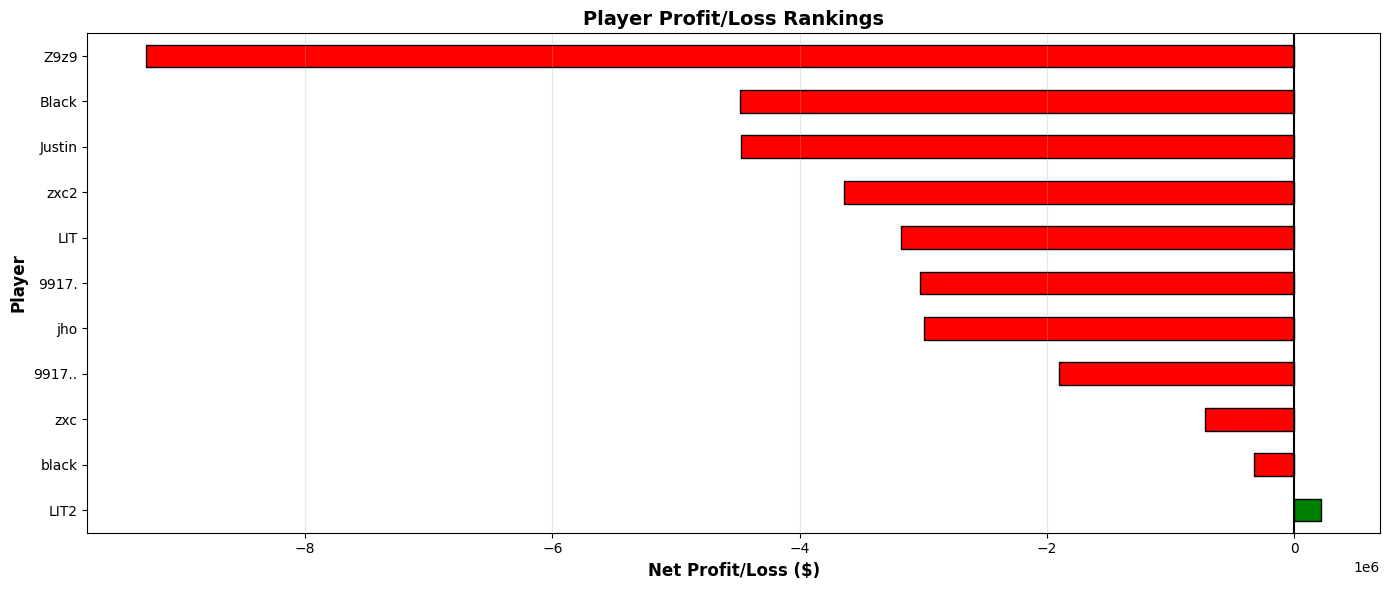

✓ Chart 1: Player Profit/Loss Rankings


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Player Profit/Loss Chart
fig, ax = plt.subplots(figsize=(14, 6))
colors = ['green' if x > 0 else 'red' for x in player_stats['net_profit']]
player_stats['net_profit'].plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.set_xlabel('Net Profit/Loss ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Player', fontsize=12, fontweight='bold')
ax.set_title('Player Profit/Loss Rankings', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Chart 1: Player Profit/Loss Rankings")

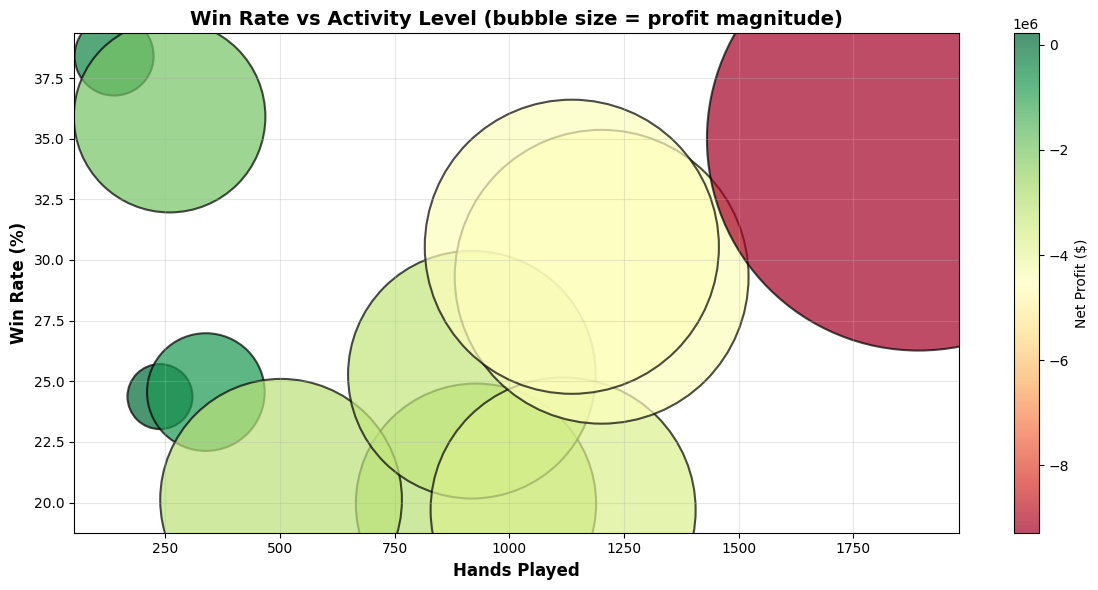

✓ Chart 2: Win Rate vs Activity Level


In [11]:
# Win Rate vs Hands Played
fig, ax = plt.subplots(figsize=(12, 6))
scatter = ax.scatter(
    player_stats['hands_played'], 
    player_stats['win_rate'],
    s=abs(player_stats['net_profit']) / 100,
    c=player_stats['net_profit'],
    cmap='RdYlGn',
    alpha=0.7,
    edgecolors='black',
    linewidth=1.5
)
ax.set_xlabel('Hands Played', fontsize=12, fontweight='bold')
ax.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Win Rate vs Activity Level (bubble size = profit magnitude)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, label='Net Profit ($)')
plt.tight_layout()
plt.show()

print("✓ Chart 2: Win Rate vs Activity Level")

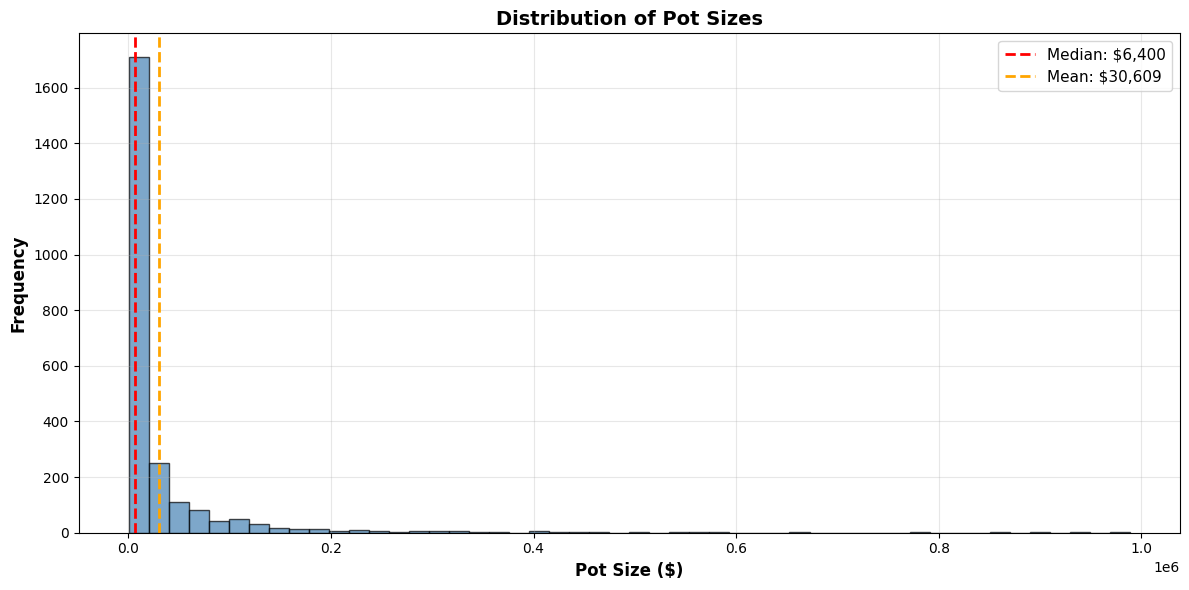

✓ Chart 3: Pot Size Distribution


In [12]:
# Pot Size Distribution
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(pots, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(pots_series.median(), color='red', linestyle='--', linewidth=2, label=f'Median: ${pots_series.median():,.0f}')
ax.axvline(pots_series.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: ${pots_series.mean():,.0f}')
ax.set_xlabel('Pot Size ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Pot Sizes', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Chart 3: Pot Size Distribution")

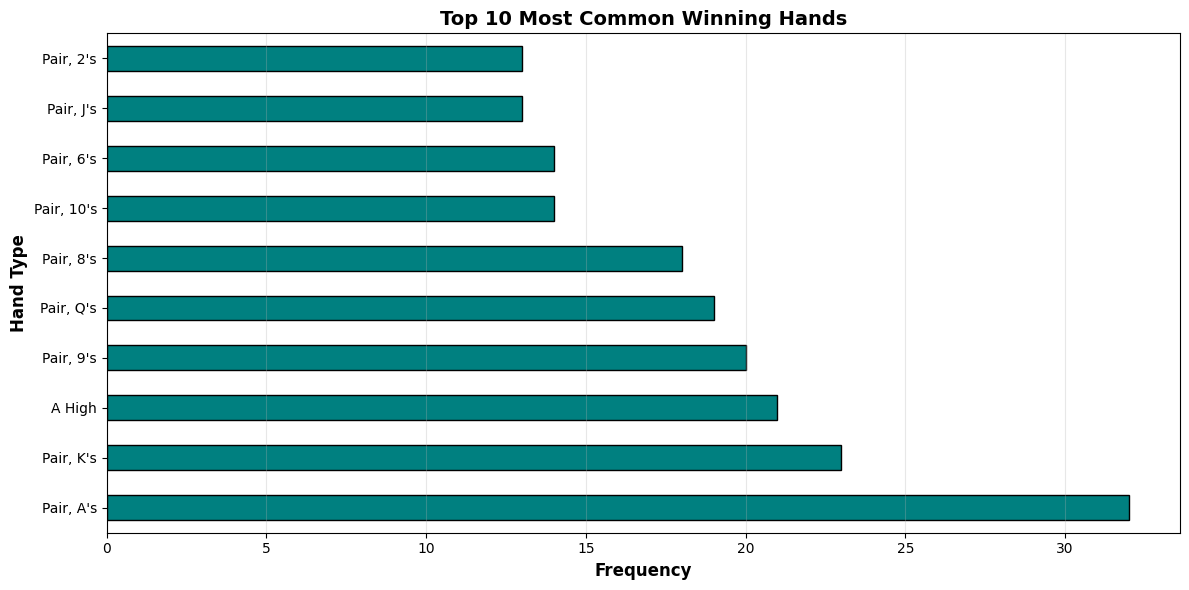

✓ Chart 4: Top Winning Hands


In [13]:
# Top Winning Hands
fig, ax = plt.subplots(figsize=(12, 6))
top_winning_hands = winning_hands_df.head(10)
top_winning_hands.plot(kind='barh', ax=ax, color='teal', edgecolor='black')
ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_ylabel('Hand Type', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Most Common Winning Hands', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Chart 4: Top Winning Hands")

## 9. Final Conclusions

In [14]:
print("\n" + "=" * 80)
print("🎯 FINAL CONCLUSIONS & RECOMMENDATIONS")
print("=" * 80)

# Calculate some final metrics
avg_win_rate = player_stats['win_rate'].mean()
total_profit_players = player_stats[player_stats['net_profit'] > 0]['net_profit'].sum()
total_loss_players = abs(player_stats[player_stats['net_profit'] < 0]['net_profit'].sum())

print(f"\n📊 OVERALL GAME DYNAMICS:")
print(f"   • Average Win Rate Across All Players: {avg_win_rate:.1f}%")
print(f"   • Total Winnings (Winners): ${total_profit_players:,.0f}")
print(f"   • Total Losses (Losers): ${total_loss_players:,.0f}")
print(f"   • Money Transfer Balance: ${abs(total_profit_players - total_loss_players):,.0f}")

print(f"\n🎓 KEY TAKEAWAYS:")
print(f"   1. Only {profitable} out of {len(player_stats)} players ({profitable/len(player_stats)*100:.1f}%) were profitable")
print(f"   2. The top performer ({player_stats.index[0]}) has a {winner['roi']:.1f}% ROI")
print(f"   3. Most common winning hand: {winning_hands_df.index[0]}")
print(f"   4. Average pot size is ${pots_series.mean():,.0f}, with largest pot at ${pots_series.max():,.0f}")
print(f"   5. {len(winning_hands)} hands ({len(winning_hands)/len(hands)*100:.1f}%) went to showdown")

print(f"\n💡 STRATEGIC INSIGHTS:")
high_roi_players = player_stats[player_stats['roi'] > 0].nlargest(3, 'roi')
print(f"   • Players with positive ROI should maintain their aggressive strategy")
print(f"   • Top 3 ROI Players:")
for i, (player, data) in enumerate(high_roi_players.iterrows(), 1):
    print(f"      {i}. {player}: {data['roi']:.1f}% ROI ({int(data['hands_played'])} hands)")

print("\n" + "=" * 80)
print("Analysis complete! 🎉")
print("=" * 80)


🎯 FINAL CONCLUSIONS & RECOMMENDATIONS

📊 OVERALL GAME DYNAMICS:
   • Average Win Rate Across All Players: 27.6%
   • Total Winnings (Winners): $219,375
   • Total Losses (Losers): $34,029,256
   • Money Transfer Balance: $33,809,881

🎓 KEY TAKEAWAYS:
   1. Only 1 out of 11 players (9.1%) were profitable
   2. The top performer (LIT2) has a 7.4% ROI
   3. Most common winning hand: Pair, A's
   4. Average pot size is $30,609, with largest pot at $988,600
   5. 646 hands (27.1%) went to showdown

💡 STRATEGIC INSIGHTS:
   • Players with positive ROI should maintain their aggressive strategy
   • Top 3 ROI Players:
      1. LIT2: 7.4% ROI (238 hands)

Analysis complete! 🎉


## 11. All-In EV Analysis

In [15]:
# All-in EV calculation
def analyze_allin_hands(hands_data):
    """Identify hands that went all-in before the river"""
    allin_hands = []
    
    for hand in hands_data:
        went_allin = False
        for player, data in hand['players'].items():
            invested = data.get('invested', 0)
            initial_stack = data.get('initial_stack', 0)
            
            if initial_stack > 0 and invested >= initial_stack:
                went_allin = True
                break
        
        has_showdown = any(p.get('hole_cards') for p in hand['players'].values())
        
        if went_allin and has_showdown:
            allin_hands.append(hand)
    
    return allin_hands

allin_hands = analyze_allin_hands(hands)

print("\n♠️ ALL-IN ANALYSIS")
print("=" * 80)
print(f"Total All-In Situations (with showdown): {len(allin_hands)}")

if allin_hands:
    allin_stats = defaultdict(lambda: {'total_allin': 0, 'won': 0, 'lost': 0, 'chips_won': 0, 'chips_lost': 0})
    
    for hand in allin_hands:
        winner = hand.get('winner')
        for player, data in hand['players'].items():
            unified_player = player_full_to_unified.get(player, player)
            invested = data.get('invested', 0)
            initial_stack = data.get('initial_stack', 0)
            
            if invested >= initial_stack and initial_stack > 0:
                allin_stats[unified_player]['total_allin'] += 1
                
                if player == winner:
                    allin_stats[unified_player]['won'] += 1
                    allin_stats[unified_player]['chips_won'] += hand.get('pot', 0) - invested
                else:
                    allin_stats[unified_player]['lost'] += 1
                    allin_stats[unified_player]['chips_lost'] += invested
    
    allin_df = pd.DataFrame.from_dict(allin_stats, orient='index')
    allin_df['win_rate'] = (allin_df['won'] / allin_df['total_allin'] * 100).round(1)
    allin_df['net_allin_result'] = allin_df['chips_won'] - allin_df['chips_lost']
    allin_df = allin_df.sort_values('net_allin_result', ascending=False)
    
    print("\nAll-In Performance by Player:")
    print(allin_df)
    
    print(f"\n📊 KEY ALL-IN INSIGHTS:")
    best_allin = allin_df.iloc[0]
    print(f"   • Best All-In Player: {allin_df.index[0]}")
    print(f"   • Win Rate: {best_allin['win_rate']:.1f}%")
    print(f"   • Net Result: ${best_allin['net_allin_result']:,.0f}")
else:
    print("\nNo all-in situations found in the data.")
    
print("\n⚠️  Note: True EV calculation requires hand equity at all-in moment.")
print("   This analysis shows actual results, not theoretical EV.")


♠️ ALL-IN ANALYSIS
Total All-In Situations (with showdown): 36

All-In Performance by Player:
        total_allin  won  lost  chips_won  chips_lost  win_rate  \
Justin            8    4     4     786153      826351      50.0   
black             1    0     1          0       51350       0.0   
zxc2              3    2     1     537336      619112      66.7   
9917.             7    1     6      24200      597226      14.3   
Black             3    0     3          0      620513       0.0   
LIT               4    1     3    -620956      107349      25.0   
Z9z9              9    4     5     402400     1310708      44.4   
jho               5    0     5          0      986986       0.0   

        net_allin_result  
Justin            -40198  
black             -51350  
zxc2              -81776  
9917.            -573026  
Black            -620513  
LIT              -728305  
Z9z9             -908308  
jho              -986986  

📊 KEY ALL-IN INSIGHTS:
   • Best All-In Player: Justin
  

## 12. Positional Analysis

In [16]:
# Positional analysis
def get_position(hand, player):
    """Determine player's position in the hand"""
    players = list(hand['players'].keys())
    num_players = len(players)
    
    if num_players < 2:
        return 'Unknown'
    
    dealer = hand.get('dealer')
    if not dealer or dealer not in players:
        return 'Unknown'
    
    dealer_idx = players.index(dealer)
    player_idx = players.index(player) if player in players else -1
    
    if player_idx == -1:
        return 'Unknown'
    
    position_offset = (player_idx - dealer_idx) % num_players
    
    if num_players == 2:
        return 'BTN' if position_offset == 0 else 'BB'
    elif num_players <= 6:
        positions = ['BTN', 'SB', 'BB', 'UTG', 'MP', 'CO']
        return positions[position_offset] if position_offset < len(positions) else 'MP'
    else:
        positions = ['BTN', 'SB', 'BB', 'UTG', 'UTG+1', 'MP', 'MP+1', 'HJ', 'CO']
        return positions[position_offset] if position_offset < len(positions) else 'MP'

# Calculate positional statistics
positional_stats = defaultdict(lambda: defaultdict(lambda: {
    'hands': 0, 'won': 0, 'invested': 0, 'won_chips': 0
}))

for hand in hands:
    winner = hand.get('winner')
    for player, data in hand['players'].items():
        unified_player = player_full_to_unified.get(player, player)
        position = get_position(hand, player)
        
        positional_stats[unified_player][position]['hands'] += 1
        positional_stats[unified_player][position]['invested'] += data.get('invested', 0)
        
        if player == winner:
            positional_stats[unified_player][position]['won'] += 1
            positional_stats[unified_player][position]['won_chips'] += hand.get('pot', 0)

print("\n🎯 POSITIONAL ANALYSIS")
print("=" * 80)

most_active_player = player_stats.index[player_stats['hands_played'].argmax()]
print(f"\nPositional Stats for {most_active_player}:")
print("-" * 80)

if most_active_player in positional_stats:
    pos_data = []
    for position, stats in positional_stats[most_active_player].items():
        if stats['hands'] > 0:
            win_rate = (stats['won'] / stats['hands'] * 100)
            net_profit = stats['won_chips'] - stats['invested']
            
            pos_data.append({
                'Position': position,
                'Hands': stats['hands'],
                'Win Rate %': round(win_rate, 1),
                'Invested': stats['invested'],
                'Won': stats['won_chips'],
                'Net': net_profit
            })
    
    pos_df = pd.DataFrame(pos_data).sort_values('Hands', ascending=False)
    print(pos_df.to_string(index=False))
    
    print(f"\n💡 POSITIONAL INSIGHTS for {most_active_player}:")
    best_position = pos_df.loc[pos_df['Net'].idxmax()]
    worst_position = pos_df.loc[pos_df['Net'].idxmin()]
    print(f"   • Most Profitable Position: {best_position['Position']} (Net: ${best_position['Net']:,.0f})")
    print(f"   • Least Profitable Position: {worst_position['Position']} (Net: ${worst_position['Net']:,.0f})")

print(f"\n✓ Positional data calculated for all {len(positional_stats)} players")


🎯 POSITIONAL ANALYSIS

Positional Stats for Z9z9:
--------------------------------------------------------------------------------
Position  Hands  Win Rate %  Invested     Won      Net
      BB    553        42.5   7782815 5546136 -2236679
     BTN    549        31.9   6990984 4262000 -2728984
      SB    432        37.3   7829988 5246500 -2583488
     UTG    197        27.9   2247775 1845376  -402399
      MP    109        20.2   2127100  951200 -1175900
      CO     32        31.2    505850  500300    -5550
 Unknown     14        21.4    159550   23800  -135750
    MP+1      4         0.0      2800       0    -2800
   UTG+1      2        50.0     48400   33600   -14800

💡 POSITIONAL INSIGHTS for Z9z9:
   • Most Profitable Position: MP+1 (Net: $-2,800)
   • Least Profitable Position: BTN (Net: $-2,728,984)

✓ Positional data calculated for all 11 players


## 13. Hand Range Matrix (Showdown Hands)

In [17]:
# Hand range matrix visualization
def parse_hole_cards(cards):
    """Convert hole cards to hand notation (e.g., ['A♥', 'K♠'] -> 'AKo')"""
    if not cards or len(cards) != 2:
        return None
    
    rank_order = '23456789TJQKA'
    card1_rank, card1_suit = cards[0][0], cards[0][1]
    card2_rank, card2_suit = cards[1][0], cards[1][1]
    
    if rank_order.index(card1_rank) >= rank_order.index(card2_rank):
        high_rank, low_rank = card1_rank, card2_rank
        suited = card1_suit == card2_suit
    else:
        high_rank, low_rank = card2_rank, card1_rank
        suited = card1_suit == card2_suit
    
    if high_rank == low_rank:
        return f"{high_rank}{high_rank}"
    else:
        return f"{high_rank}{low_rank}{'s' if suited else 'o'}"

# Collect all showdown hands for each player
player_ranges = defaultdict(lambda: defaultdict(int))

for hand in hands:
    for player, data in hand['players'].items():
        hole_cards = data.get('hole_cards')
        if hole_cards:
            unified_player = player_full_to_unified.get(player, player)
            hand_notation = parse_hole_cards(hole_cards)
            if hand_notation:
                player_ranges[unified_player][hand_notation] += 1

# Create hand matrix
def create_hand_matrix():
    """Create 13x13 matrix of all possible starting hands"""
    ranks = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']
    matrix = []
    
    for i, rank1 in enumerate(ranks):
        row = []
        for j, rank2 in enumerate(ranks):
            if i == j:
                row.append(f"{rank1}{rank2}")
            elif i < j:
                row.append(f"{rank1}{rank2}s")
            else:
                row.append(f"{rank2}{rank1}o")
        matrix.append(row)
    
    return matrix, ranks

hand_matrix, ranks = create_hand_matrix()

print("\n🃏 HAND RANGE ANALYSIS")
print("=" * 80)
print(f"Collected showdown data for {len(player_ranges)} players")
print(f"\nCreating range matrix...")
print("(AA in top-left, 22 in bottom-right, suited hands in upper-right triangle)")



🃏 HAND RANGE ANALYSIS
Collected showdown data for 11 players

Creating range matrix...
(AA in top-left, 22 in bottom-right, suited hands in upper-right triangle)



Players with showdown data:
   1. Z9z9: 223 showdowns
   2. Justin: 119 showdowns
   3. Black: 106 showdowns
   4. LIT: 99 showdowns
   5. zxc2: 74 showdowns

Generating range matrix for Z9z9...


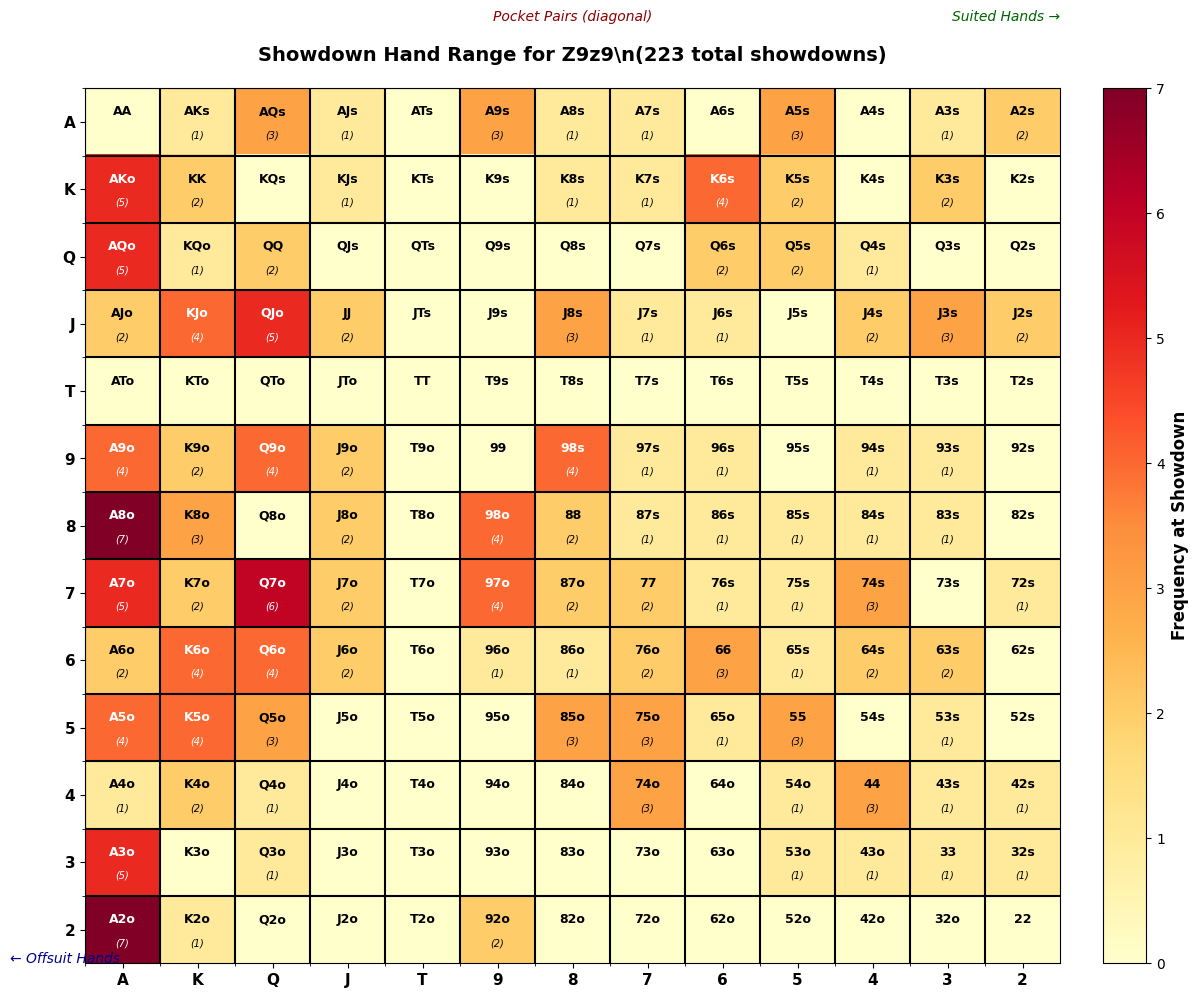


Most common showdown hands for Z9z9:
   1. A8o: 7 times
   2. A2o: 7 times
   3. Q7o: 6 times
   4. A7o: 5 times
   5. QJo: 5 times
   6. AQo: 5 times
   7. AKo: 5 times
   8. A3o: 5 times
   9. A9o: 4 times
   10. K6s: 4 times


In [18]:
# Visualize hand range for a specific player
def plot_hand_range_heatmap(player_name, player_range_data):
    """Create colorful heatmap of player's showdown range"""
    
    # Create frequency matrix
    freq_matrix = np.zeros((13, 13))
    
    for i, rank1 in enumerate(ranks):
        for j, rank2 in enumerate(ranks):
            hand = hand_matrix[i][j]
            freq_matrix[i][j] = player_range_data.get(hand, 0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create heatmap with custom colormap
    im = ax.imshow(freq_matrix, cmap='YlOrRd', aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(13))
    ax.set_yticks(np.arange(13))
    ax.set_xticklabels(ranks, fontsize=11, fontweight='bold')
    ax.set_yticklabels(ranks, fontsize=11, fontweight='bold')
    
    # Add grid
    ax.set_xticks(np.arange(13) - 0.5, minor=True)
    ax.set_yticks(np.arange(13) - 0.5, minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5)
    
    # Add hand labels and frequencies
    for i in range(13):
        for j in range(13):
            hand = hand_matrix[i][j]
            freq = freq_matrix[i][j]
            
            # Determine text color based on background
            text_color = 'white' if freq > freq_matrix.max() * 0.5 else 'black'
            
            # Add hand notation
            ax.text(j, i - 0.15, hand, ha='center', va='center', 
                   fontsize=9, fontweight='bold', color=text_color)
            
            # Add frequency if > 0
            if freq > 0:
                ax.text(j, i + 0.2, f'({int(freq)})', ha='center', va='center',
                       fontsize=7, color=text_color, style='italic')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Frequency at Showdown', fontsize=12, fontweight='bold')
    
    # Title and labels
    total_showdowns = sum(player_range_data.values())
    ax.set_title(f'Showdown Hand Range for {player_name}\\n({total_showdowns} total showdowns)',
                fontsize=14, fontweight='bold', pad=20)
    
    # Add annotations
    ax.text(12.5, -1.5, 'Suited Hands →', fontsize=10, ha='right', style='italic', color='darkgreen')
    ax.text(-1.5, 12.5, '← Offsuit Hands', fontsize=10, ha='left', style='italic', color='darkblue')
    ax.text(6, -1.5, 'Pocket Pairs (diagonal)', fontsize=10, ha='center', style='italic', color='darkred')
    
    plt.tight_layout()
    plt.show()
    
    return freq_matrix

# Plot for most active player with showdown data
if player_ranges:
    # Find player with most showdowns
    players_with_showdowns = [(p, sum(hands.values())) for p, hands in player_ranges.items()]
    players_with_showdowns.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nPlayers with showdown data:")
    for i, (player, count) in enumerate(players_with_showdowns[:5], 1):
        print(f"   {i}. {player}: {count} showdowns")
    
    # Plot for top player
    top_player = players_with_showdowns[0][0]
    print(f"\nGenerating range matrix for {top_player}...")
    
    freq_matrix = plot_hand_range_heatmap(top_player, player_ranges[top_player])
    
    # Show most common hands
    top_hands = sorted(player_ranges[top_player].items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nMost common showdown hands for {top_player}:")
    for i, (hand, freq) in enumerate(top_hands, 1):
        print(f"   {i}. {hand}: {freq} times")
else:
    print("\nNo showdown data available for range analysis.")

### Generate Range Chart for Any Player

Generating range chart for: Justin


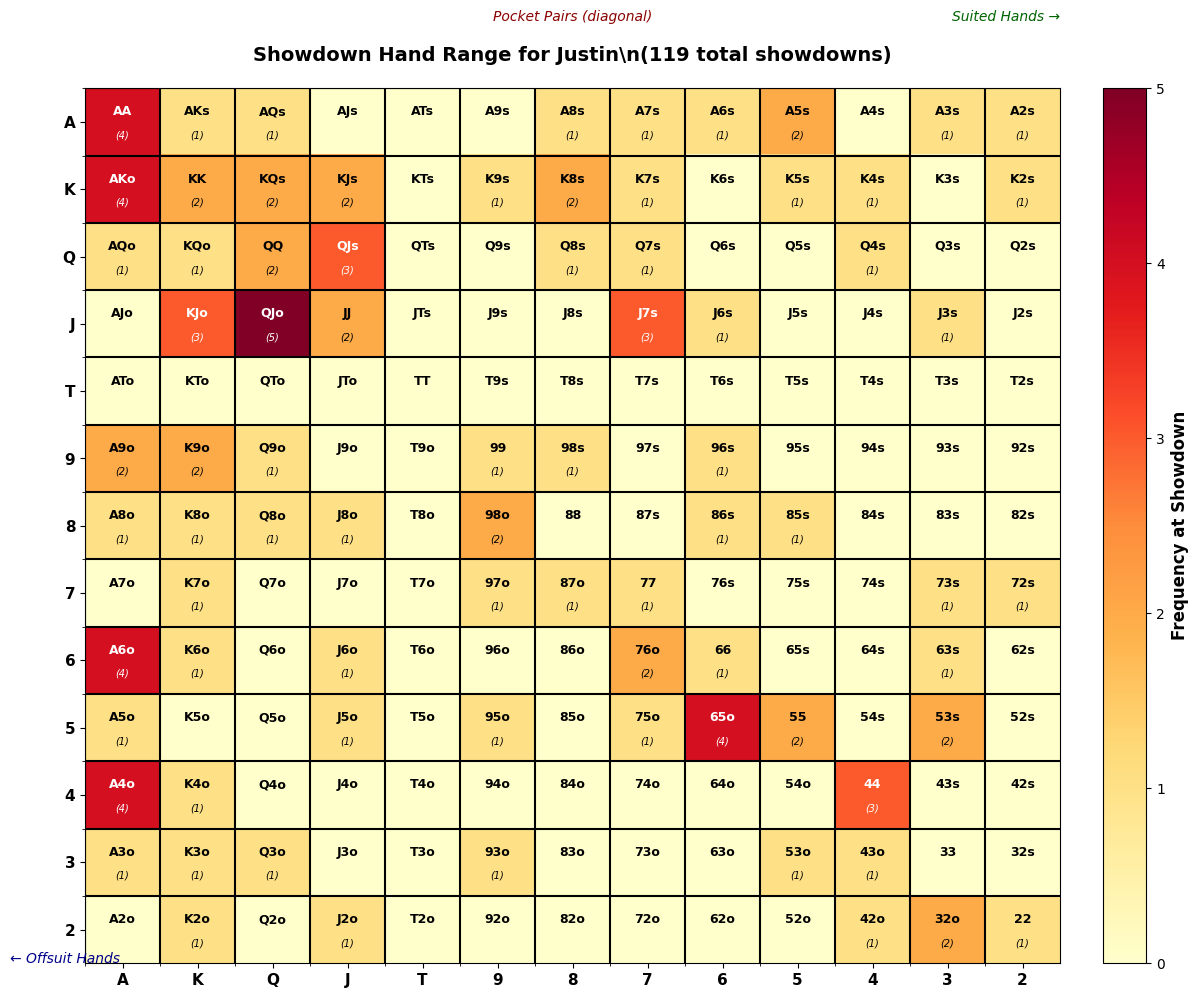


Top 15 showdown hands for Justin:
    1. QJo  - 5 times
    2. AKo  - 4 times
    3. A6o  - 4 times
    4. 65o  - 4 times
    5. AA   - 4 times
    6. A4o  - 4 times
    7. QJs  - 3 times
    8. 44   - 3 times
    9. KJo  - 3 times
   10. J7s  - 3 times
   11. K9o  - 2 times
   12. K8s  - 2 times
   13. JJ   - 2 times
   14. QQ   - 2 times
   15. 53s  - 2 times


In [20]:
# Generate range chart for a specific player
# EDIT THE PLAYER NAME BELOW:
selected_player = "Justin"  # Change this to any player name

if selected_player in player_ranges:
    print(f"Generating range chart for: {selected_player}")
    freq_matrix = plot_hand_range_heatmap(selected_player, player_ranges[selected_player])
    
    # Show top hands
    top_hands = sorted(player_ranges[selected_player].items(), key=lambda x: x[1], reverse=True)[:15]
    print(f"\nTop 15 showdown hands for {selected_player}:")
    for i, (hand, freq) in enumerate(top_hands, 1):
        print(f"   {i:2}. {hand:4} - {freq} times")
else:
    print(f"Player '{selected_player}' not found or has no showdown data.")
    print(f"\nAvailable players with showdown data:")
    for player in sorted(player_ranges.keys()):
        print(f"   • {player}")